# Bernoulli Embeddings
### *A demonstration using the MovieLens dataset*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yabramuvdi/yabramuvdi.github.io/blob/master/_notebooks/movies_embeddings_estimation.ipynb)

This notebook builds on the Exponential Family Embeddings framework developed by [Rudolph et al. (2016)](https://arxiv.org/pdf/1608.00778.pdf) in order to estimate dense low-dimensional representations of movies. In essence, we will construct these representations by leveraging the consumption patterns of users.

Under the hood, the code that we will use is written in Python and mainly uses JAX to estimate the embeddings. You can find the repository [here](https://github.com/yabramuvdi/bernoulli-embeddings). You can also explore an additional notebook that uses these embedded representations and a [recommender system](https://movies-embeddings.herokuapp.com/) I built with them.

## Motivation, theory, and model

### Motivation

Word embeddings have proven to be powerful low-dimensional continuous representation of words. Essentially, embeddings capture the intuition that a word can be described by the context in which it appears. Words that occur in similar contexts usually have similar meanings. Embeddings are used in many natural language processsing (NLP) tasks, such as predicting the next three words on your smart phone. [Rudolph et al. (2016)](https://arxiv.org/pdf/1608.00778.pdf) extend word embeddings to other types of high-dimensional data, including neural data and movie recommendation systems. <br><br>


We rely on their methodological development to estimate low-dimensional dense representations of movies. Movies are observations with many characteristics in several dimensions: genre, actors, year of release, etc. We can try to compare movies along these many dimensions. But we can also map these multi-dimensional points to a lower latent spaces. We generate these embedded representations of movies by identifying all the movies that were highly ranked by the same user. The main idea is that there is a lot of information encoded in the fact that the same user ranks highly multiple movies. A user that likes Toy Story and Finding Nemo will probably also rank very highly Coco. <br><br>

In terms of mechanics, the goal is to model each movie conditional on a set of other movies (the "context"). Each movie is associated with two latent vectors: an embedding vector $\rho$ and a context vector $\alpha$. Both jointly determine the conditional probability that relates each movie to its context. We will now develop a little bit more of the model before showing how to estimate it.

### The model

We want to model the conditional probability that a movie $i$ is highly ranked by user $j$, given the existing set of movies that user $j$ has ranked highly. Let $S_j$ be the set of all movies that user $j$ ranks highly, and $S_j^{-i}$ that set without movie $i$. <br><br>

We consider the simplest setting, a Bernoulli embedding, in which movie $i$ is part of $S_j$ with probability $p_i$. Then, $i$ follows a Bernoulli distribution with parameter $p_i$:

\begin{equation}
    i \in S_j | S_j^{-i} \sim Bernoulli(p_i) \quad \textrm{and} \quad p_i \equiv P \left(i \in S_j | S_j^{-i} \right)
\end{equation}

**The fundamental idea behind embeddings is that we can parametrize this conditional probability using two types of low-dimensional continuous vectors: embeddings and context vectors**. For each movie $i$ we will have a $K$-dimensional embedding vector $\rho_i = \left[\rho_{i,1}, \rho_{i,2}, ... , \rho_{i,K} \right]$ and a $K$-dimensional context vector $\alpha_i = \left[\alpha_{i,1}, \alpha_{i,2}, ... , \alpha_{i,K} \right]$. The choice of $K$ is up to the modeler: higher $K$ implies more detailed embeddings, but at the expense of computational cost. <br><br>

There are several classes of models that specify how the $\rho$ and $\alpha$ vectors exactly interact with each other in order to define the conditional probability of interest. We choose a simple parameterization of the embedding structure: (i) a linear combination of the embeddings vectors to model the conditional probabilities, and (ii) a sigmoid link function to map outcomes to admissible probabilities. <br><br>

First, we use a linear combination of the embeddings vectors to model the conditional probability. Intuitively, we want to have the embedding of movie $i$, $\rho_i$, to be as similar as possible to the context embeddings $\alpha$ of the rest of movies that were ranked highly by user $j$. Formally, we combine the embedding $\rho_i$ with the context embeddings of the other movies by computing: <br><br>
    \begin{equation}
        \rho_i^T \sum_{s \in S_j^{-i}} \alpha_s
    \end{equation}

Second, we choose a link function to map outcomes to probabilities. We normalize by the number of movies that are part of the context, $\frac{1}{\#S_j^{-i}}$, to account for the fact that each user ranks a different number of movies. Then, we use a **sigmoid link function** $\sigma(\cdot)$ to transform the value that we have into a number between 0 and 1 to obtain admissible probabilities. <br><br>

These two ingredients lead to our model for a single conditional probability:

\begin{equation}
    P \left(i \in S_j | S_j^{-i} \right) = f_i \left( \rho_i^T \sum_{s \in S_j^{-i}} \alpha_s \right) = \sigma \left( \frac{1}{\#S_j^{-i}} \; \rho_i^T \sum_{s \in S_j^{-i}} \alpha_s \right) 
\end{equation}

In order to construct a complete probability for the observed data, we also need to model the probability of a movie $g$ \emph{not} not being ranked by user $j$:

\begin{equation}
\begin{aligned}
Pr \left(g \notin S_j | S_j \right) = 1 - Pr \left(g \in S_j | S_j \right) = 1 - \sigma \left( \frac{1}{\#S_j} \rho_g^T \sum_{s \in S_j} \alpha_s \right)
\end{aligned}
\end{equation}

This term needs to be computed for all possible movies $g$  that are not ranked by user $j$, which makes the problem extremely computationally expensive. However, following the word embeddings literature, we can randomly sample a subset of $g$ movies to compute this term. If the size of the random sample is considerably smaller than the number of suppliers, we can compute this term at a reasonable computational cost. This strategy is known as **negative sampling**. 

Bringing everything together, for a single user we have the following conditional log probability:

\begin{equation}
    \mathcal{L}_j(\rho, \alpha) = \sum_{i \in S_j} \log \sigma \left(\frac{1}{\#S_j^{-i}} \rho_i^T \sum_{s \in S_j^{-i}} \alpha_s \right) +  \sum_{k \in NS} \log \left( 1 - \sigma \left( \frac{1}{\#S_j} \rho_k^T \sum_{s \in S_j} \alpha_s \right) \right)
\end{equation}

Summing over all observations, and including regularization terms on both sets of embeddings, the full objective function is given by

\begin{equation}
   \begin{aligned}
           \mathcal{L}(\rho, \alpha) & = \sum_{j \in C} \sum_{i \in S_j} \log \sigma \left(\frac{1}{\#S_j^{-i}} \rho_i^T \sum_{s \in S_j^{-i}} \alpha_s \right) + \\ & 
           \gamma \sum_{j \in C} \sum_{k \in NS} \log \left( 1 - \sigma \left( \frac{1}{\#S_j^{-i}} \rho_k^T \sum_{s \in S_j} \alpha_s \right) \right)  +
           \log p (\rho)+ \log p (\alpha)
   \end{aligned} 
\end{equation}

The first term describes the conditional probability of a movie $i$ being highly ranked by user $j$. The second term correspond to the negative samples, and the last two terms describe the priors we have on both embeddings vectors.

## Estimation

We will use our own custom code (available [here](https://github.com/yabramuvdi/bernoulli-embeddings)) in order to estimate these embeddings.

### Setup

In [ ]:
# check that we got GPU
!nvidia-smi

Wed Nov  2 17:11:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install a optimization library for JAX
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 32.0 MB/s 
     |████████████████████████████████| 85 kB 4.7 MB/s 


In [ ]:
# clone the repository with the source code
!git clone https://github.com/yabramuvdi/bernoulli-embeddings.git

Cloning into 'bernoulli-embeddings'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 23 (delta 7), reused 15 (delta 2), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [ ]:
# get data from MovieLens
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip

--2022-11-02 17:12:09--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  11.0MB/s    in 21s     

2022-11-02 17:12:32 (11.8 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [ ]:
# unzip data
!unzip ml-25m.zip

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [ ]:
import sys
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import optax

# add path to read our source code
sys.path.insert(0, "./bernoulli-embeddings/src")
import data_generation as dg
import bernoulli_embeddings as be

In [ ]:
# define data path
input_path = "./ml-25m/"

In [ ]:
# check if GPU is being used by JAX
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


### MovieLense data

The MovieLens 25M dataset contains the ratings given by 162,000 users to 62,000 movies. We will simplify the data by keeping only the movies that were rated with 5 stars and dropping movies that were rated by very few users. This way we are able to focus only on the set of movies that users clearly liked and were watched by many users.
<br><br>

Check the [official webpage](https://grouplens.org/datasets/movielens/) for more information.


In [ ]:
# read original data
df = pd.read_csv(input_path + "ratings.csv")
df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [ ]:
# rename columns
df.columns = ["user_id", "movie_id", "rating", "time"]

# keep only the ratings for movies that people loved (5 stars)
df = df.loc[df["rating"] > 4]

We will use the more generic names of *basket* (instead of user) and *item* (instead of movie). In a way, users can be thought of as baskets that contain multiples items (i.e. all the movies that they have liked).

In [ ]:
# simplify and rename columns
df = df[["user_id", "movie_id"]]
df.columns = ["basket", "item"]
df

,basket,item
0,1,296
2,1,307
3,1,665
8,1,1237
16,1,2351
...,...,...
25000085,162541,8983
25000086,162541,31658
25000089,162541,45517
25000090,162541,50872


In [ ]:
# drop movies that appear less than a min number of times
df = dg.drop_items(df, min_times=50)
df

,basket,item
0,1,296
1,3,296
2,8,296
3,10,296
4,12,296
...,...,...
5639968,151652,1976
5639969,156667,1976
5639970,158748,1976
5639971,160329,1976


In [ ]:
# remove any basket that has less than 2 items
df = dg.check_baskets(df, min_items=2)
df

,basket,item
0,1,296
1,3,296
2,8,296
3,10,296
4,12,296
...,...,...
5637129,151652,1976
5637130,156667,1976
5637131,158748,1976
5637132,160329,1976


### Prepare data

In order to estimate our embeddings we need to transform the data structure we currently have. Instead of having pairs of (basket, item) we want to group together all the items that belong to the same basket.

In [ ]:
# generate indexes for all the baskets and items in our data
df_train, basket2idx, item2idx = dg.gen_indexes(df, 
                                                basket_col="basket",
                                                item_col="item")
df_train

,basket,item,basket_idx,item_idx
0,1,296,1,226
1,3,296,3,226
2,8,296,8,226
3,10,296,10,226
4,12,296,12,226
...,...,...,...,...
5637129,151652,1976,147020,1237
5637130,156667,1976,151901,1237
5637131,158748,1976,153928,1237
5637132,160329,1976,155468,1237


In [ ]:
# generate JAX arrays (this will take several minutes)
start = time.time()
all_baskets = list(basket2idx.values())
items_per_basket, all_baskets, all_items, all_nonzero = dg.gen_data(df_train, 
                                                                    basket_idxs=None, 
                                                                    max_items=100)
duration = np.round((time.time() - start)/60, 2)
print(f"Duration of data generation: {duration} minutes")
print(all_baskets.shape, all_items.shape, all_nonzero.shape)


Duration of data generation: 8.79 minutes
(157604,) (157604, 100) (157604, 100, 1)


In [ ]:
# explore the number of baskets and unique items (movies)
print(f"Number of baskets: {len(basket2idx)}")
print(f"Number of movies: {len(item2idx)}")

Number of baskets: 157604
Number of movies: 6082


### Estimating the embeddings

Now we can simply define the parameters of the model and estimate the embeddings use our custom class.

In [ ]:
# create a dictionary with the model parameters and a random number generator
model_args, generator = be.gen_model_args(seed=92, 
                                          num_items=len(item2idx), 
                                          num_baskets=len(basket2idx),
                                          embedded_dim=50, 
                                          init_mean=0.0, 
                                          init_std=0.1/np.sqrt(50),
                                          rho_var=1.0,
                                          alpha_var=1.0,
                                          zero_factor=0.1,
                                          num_epochs=8000,
                                          batch_size=int(0.05*len(basket2idx)),
                                          ns_multiplier=50,
                                          num_ns=10,
                                          print_loss_freq=500,
                                          save_params_freq=500
                                          )


In [ ]:
# initialize parameters
params = be.init_params(model_args, generator)
print(params.rho.shape, params.alpha.shape)

(6083, 50) (6083, 50)


In [ ]:
# create optimizer from OPTAX library
optimizer = optax.adam(learning_rate=0.01, 
                       b1=0.9, b2=0.999)
optimizer

GradientTransformation(init=<function chain.<locals>.init_fn at 0x7f919a5cd560>, update=<function chain.<locals>.update_fn at 0x7f919a5cd5f0>)

In [ ]:
# initialize current optimal state with initial parameters
opt_state = optimizer.init(params)

In [ ]:
# train the model!
final_params = be.train(params,
                        optimizer,
                        opt_state,
                        items_per_basket, 
                        all_baskets, 
                        all_items,
                        all_nonzero,
                        model_args,
                        generator,
                        output_path="./")

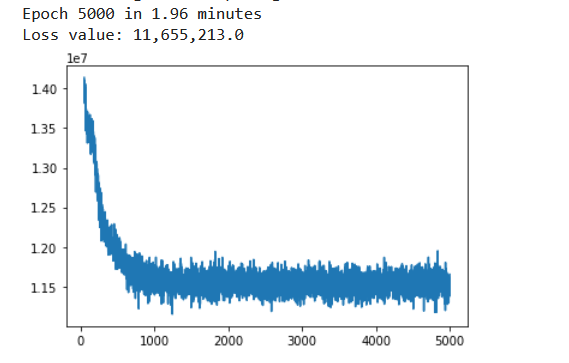